# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

We have obtained very encouraging results in part 10 to tackle collateral Learning. We will now change the collateral model and see if we can increase the collateral accuracy

# 1. Joint optimisation


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [10]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [11]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

## 1. Advanced CNN collateral model

In [12]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture.

In [13]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin3 = nn.Linear(8, 16)
        self.lin4 = nn.Linear(16, N_FONTS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for font families advanced
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x
    
    def conv_font_advanced(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font_advanced(self, x):
        x = self.quad(x)
        x = self.conv_font_advanced(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [14]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        if not advanced_collateral:
            # Optimize C and F parts of the model with 2 strategies
            if initial_phase:  # Normal optimisation of C
                # Phase 1: Optimise Q + C
                optimizer.zero_grad()
                output = model.forward_char(data)
                loss_char = F.nll_loss(output, target_char)
                loss_char.backward()
                optimizer.step()
            else: # Freezed(Q) optimisation
                # Phase 1: Optimise Freezed(Q) + F
                model.freeze('quad')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)
                loss_char.backward()
                optimizer.step()
                model.unfreeze()
            # Phase 2: Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()

            if perturbate:
                # Optimize Q
                model.freeze('font')
                model.freeze('char')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)

                output_font = model.forward_font(data)
                loss_font = F.nll_loss(output_font, target_font)

                loss = loss_char - alpha * loss_font
                loss.backward()
                optimizer.step()
                model.unfreeze()
        else:
            loss_char = None
            # advanced_collateral phase: use the CNN
            model.freeze('quad')
            optimizer.zero_grad()
            output = model.forward_font_advanced(data)
            loss_font = F.nll_loss(output, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        if loss_char is not None:
            loss_char = loss_char.item()
        else:
            loss_char = 0
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char, loss_font.item()))

In [15]:
def test(args, model, test_loader, advanced_collateral):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not advanced_collateral:
                output = model.forward_font(data)
            else:
                output = model.forward_font_advanced(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [16]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [17]:
def main(alpha=0):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + args.advanced_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        advanced = epoch > args.epochs + args.sabotage_epochs + args.recovering_epochs
        if advanced:
            print('(advanced)')
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced)
        test_perf_char, test_perf_font = test(args, model, test_loader, advanced)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

We first test with our best trade-off (alpha = 1.5)

In [18]:
results = {}
alpha=1.5
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha)
results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_clean
results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.274189 Loss Font: 1.611965
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.265387 Loss Font: 1.635894
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.210234 Loss Font: 1.603413
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.960718 Loss Font: 1.674576
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.746372 Loss Font: 1.606319
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.520875 Loss Font: 1.693831
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.502385 Loss Font: 1.530335
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.869867 Loss Font: 1.682337
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.704929 Loss Font: 1.571386
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.853957 Loss Font: 1.564422

Test set: Accuracy Char : 5181/10000 (51.81%)
          Accuracy Font : 2724/10000 (27.24%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.389632 Loss Font: 1.573540
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.075665 Loss Font: 1.382067
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.120490 Loss Font: 1.366672
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.089869 Loss Font: 1.430986
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.182974 Loss Font: 1.347614

Test set: Accuracy Char : 9256/10000 (92.56%)
          Accuracy Font : 3839/10000 (38.39%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.206772 Loss Font: 1.412854
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.188798 Loss Font: 1.468094
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.287732 Loss Font: 1.550528
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.199569 Loss Font: 1.596144
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.127771 Loss Font: 1.508987
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.203587 Loss Font: 1.538456
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.192704 Loss Font: 1.645415
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.356204 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.096239 Loss Font: 1.613945
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.130587 Loss Font: 1.574075
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.108090 Loss Font: 1.575873
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.231421 Loss Font: 1.537578
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.081390 Loss Font: 1.499637
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.192393 Loss Font: 1.531187
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.167914 Loss Font: 1.559896
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.093898 Loss Font: 1.514295
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.151769 Loss Font: 1.608005

Test set: Accuracy Char : 9328/10000 (93.28%)
          Accuracy Font : 2757/10000 (27.57%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.110620 Loss Font: 1.591324
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.176628 Loss Font: 1.603771
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.124671 Loss Font: 1.532812
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.272316 Loss Font: 1.588580

Test set: Accuracy Char : 9326/10000 (93.26%)
          Accuracy Font : 2989/10000 (29.89%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.189509 Loss Font: 1.557512
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.027276 Loss Font: 1.526435
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.139424 Loss Font: 1.506392
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.071535 Loss Font: 1.607286
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.057738 Loss Font: 1.549770
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.076328 Loss Font: 1.504646
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.307624 Loss Font: 1.579433
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.067665 Loss Font: 1.522316
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.203483 Loss Font: 1.391471
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.102182 Loss Font: 1.467473

Test set: Accuracy Char : 9318/10000 (93.18%)
          Accuracy Font : 3141

Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.041310
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.890575
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.936692
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.010932
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.014233

Test set: Accuracy Char : 9308/10000 (93.08%)
          Accuracy Font : 5704/10000 (57.04%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.046404
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.126914
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.919220
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.063714
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.911828
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.150579
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font:

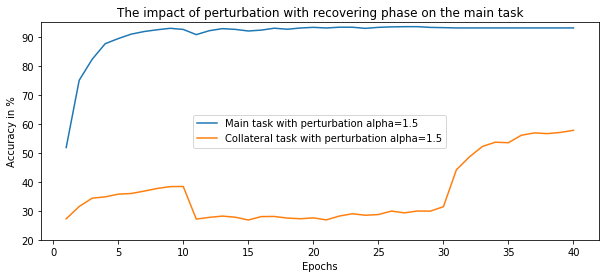

In [22]:
#main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(results, "The impact of perturbation with recovering phase on the main task", ymin=20, ymax=95)

As you observe, the collateral accuracy recover a lot, from 31% to 58%! Let's check how the value of alpha influence this.

In [23]:
alpha=0.2
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha)
results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_clean
results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.274189 Loss Font: 1.611965
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.265387 Loss Font: 1.635894
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.210234 Loss Font: 1.603413
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.960718 Loss Font: 1.674576
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.746372 Loss Font: 1.606319
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.520875 Loss Font: 1.693831
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.502385 Loss Font: 1.530335
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.869867 Loss Font: 1.682337
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.704929 Loss Font: 1.571386
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.853957 Loss Font: 1.564422

Test set: Accuracy Char : 5181/10000 (51.81%)
          Accuracy Font : 2724/10000 (27.24%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.389632 Loss Font: 1.573540
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.075665 Loss Font: 1.382067
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.120490 Loss Font: 1.366672
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.089869 Loss Font: 1.430986
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.182974 Loss Font: 1.347614

Test set: Accuracy Char : 9256/10000 (92.56%)
          Accuracy Font : 3839/10000 (38.39%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.206772 Loss Font: 1.412854
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.137813 Loss Font: 1.343657
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.160585 Loss Font: 1.394441
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.154859 Loss Font: 1.174257
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.098725 Loss Font: 1.467535
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.136393 Loss Font: 1.348932
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.080099 Loss Font: 1.492672
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.134221 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.082240 Loss Font: 1.440470
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.060699 Loss Font: 1.359541
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.079540 Loss Font: 1.443787
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.144876 Loss Font: 1.477911
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.038652 Loss Font: 1.332205
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.094796 Loss Font: 1.328921
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.089739 Loss Font: 1.341140
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.038432 Loss Font: 1.427289
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.181301 Loss Font: 1.488230

Test set: Accuracy Char : 9467/10000 (94.67%)
          Accuracy Font : 3557/10000 (35.57%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.038712 Loss Font: 1.423141
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.095748 Loss Font: 1.467024
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.052654 Loss Font: 1.458730
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.201699 Loss Font: 1.423473

Test set: Accuracy Char : 9491/10000 (94.91%)
          Accuracy Font : 3723/10000 (37.23%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.086731 Loss Font: 1.352253
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.018964 Loss Font: 1.463711
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.044583 Loss Font: 1.429324
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.040169 Loss Font: 1.536204
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.060999 Loss Font: 1.471129
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.079686 Loss Font: 1.315966
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.255034 Loss Font: 1.418153
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.030258 Loss Font: 1.311864
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.064454 Loss Font: 1.273873
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.087448 Loss Font: 1.339464

Test set: Accuracy Char : 9501/10000 (95.01%)
          Accuracy Font : 3911

Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.798631
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.749008
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.724981
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.810331
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.722890

Test set: Accuracy Char : 9494/10000 (94.94%)
          Accuracy Font : 6375/10000 (63.75%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.797890
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.954487
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.815543
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.907150
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.776771
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.956538
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font:

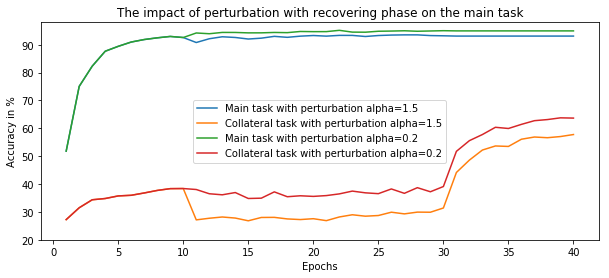

In [25]:
show_results(results, "The impact of perturbation with recovering phase on the main task", ymin=20, ymax=98)

With alpha=0.2, we see that the gain in accuracy observed only corresponds to the gain made by the first collateral model.

In [26]:
alpha=0
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha)
results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_clean
results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.274189 Loss Font: 1.611965
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.265387 Loss Font: 1.635894
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.210234 Loss Font: 1.603413
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.960718 Loss Font: 1.674576
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.746372 Loss Font: 1.606319
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.520875 Loss Font: 1.693831
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.502385 Loss Font: 1.530335
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.869867 Loss Font: 1.682337
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.704929 Loss Font: 1.571386
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.853957 Loss Font: 1.564422

Test set: Accuracy Char : 5181/10000 (51.81%)
          Accuracy Font : 2724/10000 (27.24%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.389632 Loss Font: 1.573540
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.075665 Loss Font: 1.382067
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.120490 Loss Font: 1.366672
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.089869 Loss Font: 1.430986
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.182974 Loss Font: 1.347614

Test set: Accuracy Char : 9256/10000 (92.56%)
          Accuracy Font : 3839/10000 (38.39%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.206772 Loss Font: 1.412854
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.132986 Loss Font: 1.330328
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.162294 Loss Font: 1.390017
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.153901 Loss Font: 1.150498
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.102679 Loss Font: 1.440876
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.135053 Loss Font: 1.324996
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.080348 Loss Font: 1.458191
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.116316 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.080674 Loss Font: 1.303069
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.067475 Loss Font: 1.188986
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.047208 Loss Font: 1.375126
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.154117 Loss Font: 1.303177
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.045990 Loss Font: 1.136415
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.086725 Loss Font: 1.202888
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.062696 Loss Font: 1.188001
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.047094 Loss Font: 1.390114
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.152544 Loss Font: 1.323734

Test set: Accuracy Char : 9505/10000 (95.05%)
          Accuracy Font : 4230/10000 (42.30%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.051832 Loss Font: 1.286263
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.125863 Loss Font: 1.387547
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.048645 Loss Font: 1.382624
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.200892 Loss Font: 1.206229

Test set: Accuracy Char : 9499/10000 (94.99%)
          Accuracy Font : 4288/10000 (42.88%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.043793 Loss Font: 1.277945
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.010228 Loss Font: 1.344034
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.039546 Loss Font: 1.211010
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.032687 Loss Font: 1.420516
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.055944 Loss Font: 1.387185
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.064065 Loss Font: 1.260976
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.220045 Loss Font: 1.308192
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.041562 Loss Font: 1.046296
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.040875 Loss Font: 1.279216
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.085151 Loss Font: 1.253829

Test set: Accuracy Char : 9534/10000 (95.34%)
          Accuracy Font : 4396

Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.755442
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.736701
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.666830
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.747061
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.658383

Test set: Accuracy Char : 9534/10000 (95.34%)
          Accuracy Font : 6743/10000 (67.43%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.761743
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.878346
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.651950
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.789071
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.637756
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.840510
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font:

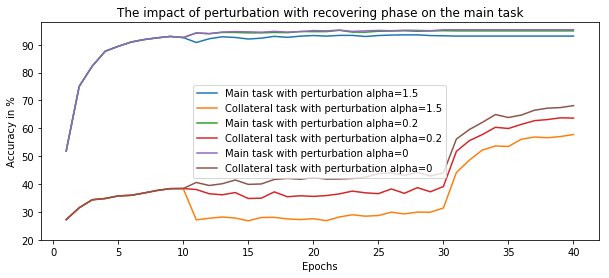

In [27]:
show_results(results, "The impact of perturbation with recovering phase on the main task", ymin=20, ymax=98)

**Observation**
So using a very different model, we succeeded in having strong recovery and a relatively high accuracy for the collateral task! This means that there is still a lot of information conveyed by the output of the private model, even if it is unexploitable for the first collateral model.

The next question we want to answer is: what if we used a slightly different model for the advanced one, and not a model which has nothing to do with the first one ? we will give more time for the last phase.

## 2. Advanced but similar collateral model

In [38]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [39]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin3 = nn.Linear(8, 16)
        self.lin4 = nn.Linear(16, N_FONTS)
        
        # --- FFN for font families advanced
        self.lin5 = nn.Linear(8, 32)
        self.lin6 = nn.Linear(32, 16)
        self.lin7 = nn.Linear(16, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x
    
    def conv_font_advanced(self, x):
        # --- FFN
        x = F.relu(self.lin5(x))
        x = F.relu(self.lin6(x))
        x = self.lin7(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font_advanced(self, x):
        x = self.quad(x)
        x = self.conv_font_advanced(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

In [40]:
ffn_results = {}
alpha=0
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha)
ffn_results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_clean
ffn_results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.312578 Loss Font: 1.600525
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.211670 Loss Font: 1.601517
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.110140 Loss Font: 1.656313
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.042775 Loss Font: 1.687863
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.713832 Loss Font: 1.613548
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.560706 Loss Font: 1.582713
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.136696 Loss Font: 1.583311
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.922120 Loss Font: 1.637017
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.941792 Loss Font: 1.713073
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.519445 Loss Font: 1.599791

Test set: Accuracy Char : 4999/10000 (49.99%)
          Accuracy Font : 2864/10000 (28.64%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.658882 Loss Font: 1.628893
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.148644 Loss Font: 1.298089
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.153211 Loss Font: 1.330578
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.389360 Loss Font: 1.390938
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.315189 Loss Font: 1.364774

Test set: Accuracy Char : 9317/10000 (93.17%)
          Accuracy Font : 4024/10000 (40.24%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.228306 Loss Font: 1.470477
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.407970 Loss Font: 1.346779
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.116384 Loss Font: 1.452109
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.129114 Loss Font: 1.390241
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.151238 Loss Font: 1.271468
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.086699 Loss Font: 1.306980
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.123521 Loss Font: 1.408366
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.189980 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.032021 Loss Font: 1.225188
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.033946 Loss Font: 1.046865
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.026567 Loss Font: 1.235780
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.013493 Loss Font: 1.219140
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.024305 Loss Font: 1.316410
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.022397 Loss Font: 1.026526
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.030867 Loss Font: 1.116902
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.136050 Loss Font: 1.254811
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.059035 Loss Font: 1.348496

Test set: Accuracy Char : 9464/10000 (94.64%)
          Accuracy Font : 4348/10000 (43.48%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.119688 Loss Font: 1.388438
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.140972 Loss Font: 1.318797
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.050669 Loss Font: 1.177065
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.107296 Loss Font: 1.281573

Test set: Accuracy Char : 9476/10000 (94.76%)
          Accuracy Font : 4477/10000 (44.77%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.095000 Loss Font: 1.276803
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.123483 Loss Font: 1.211145
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.010763 Loss Font: 1.444467
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.064903 Loss Font: 1.306599
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.100618 Loss Font: 1.220476
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.081796 Loss Font: 1.332597
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.089341 Loss Font: 1.055702
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.087425 Loss Font: 1.479090
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.039598 Loss Font: 1.113181
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.326113 Loss Font: 1.259358

Test set: Accuracy Char : 9476/10000 (94.76%)
          Accuracy Font : 4517

Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.218959
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.060390
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.057240
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.989639

Test set: Accuracy Char : 9465/10000 (94.65%)
          Accuracy Font : 5201/10000 (52.01%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.075279
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.252017
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.066325
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.300170
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.012774
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.057217
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.019448
Train Epoch: 40 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.005013
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.125349
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.172809
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.939622
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.926842
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.127503
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.208744
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.136661

Test set: Accuracy Char : 9465/10000 (94.65%)
          Accuracy Font : 5501/10000 (55.01%)
(advanced)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.980304
Train Epoch: 50 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.166695
Train Epoch: 50 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.034925
Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font:

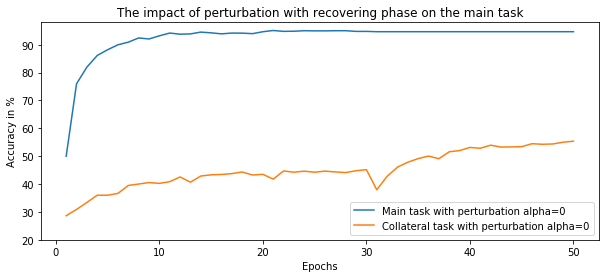

In [41]:
show_results(ffn_results, "The impact of perturbation with recovering phase on the main task", ymin=20, ymax=98)

In [42]:
for alpha in [0.2, 0.5, 1.5]:
    test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha)
    ffn_results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_clean
    ffn_results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.312578 Loss Font: 1.600525
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.211670 Loss Font: 1.601517
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.110140 Loss Font: 1.656313
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.042775 Loss Font: 1.687863
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.713832 Loss Font: 1.613548
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.560706 Loss Font: 1.582713
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.136696 Loss Font: 1.583311
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.922120 Loss Font: 1.637017
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.941792 Loss Font: 1.713073
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.519445 Loss Font: 1.599791

Test set: Accuracy Char : 4999/10000 (49.99%)
          Accuracy Font : 2864/10000 (28.64%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.658882 Loss Font: 1.628893
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.148644 Loss Font: 1.298089
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.153211 Loss Font: 1.330578
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.389360 Loss Font: 1.390938
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.315189 Loss Font: 1.364774

Test set: Accuracy Char : 9317/10000 (93.17%)
          Accuracy Font : 4024/10000 (40.24%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.228306 Loss Font: 1.470477
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.397960 Loss Font: 1.354815
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.120914 Loss Font: 1.472129
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.126273 Loss Font: 1.418172
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.165154 Loss Font: 1.298414
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.086539 Loss Font: 1.340699
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.120838 Loss Font: 1.459716
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.199293 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.027439 Loss Font: 1.377028
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.029840 Loss Font: 1.229989
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.027682 Loss Font: 1.327902
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.016439 Loss Font: 1.397251
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.021078 Loss Font: 1.447508
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.033394 Loss Font: 1.274773
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.037811 Loss Font: 1.309380
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.118885 Loss Font: 1.488569
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.058280 Loss Font: 1.505805

Test set: Accuracy Char : 9454/10000 (94.54%)
          Accuracy Font : 3514/10000 (35.14%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.158554 Loss Font: 1.488400
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.128007 Loss Font: 1.466324
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.075628 Loss Font: 1.384645
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.123514 Loss Font: 1.472621

Test set: Accuracy Char : 9463/10000 (94.63%)
          Accuracy Font : 3659/10000 (36.59%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.139570 Loss Font: 1.406759
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.096789 Loss Font: 1.384476
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.013700 Loss Font: 1.469993
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.060960 Loss Font: 1.462368
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.099408 Loss Font: 1.488416
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.056121 Loss Font: 1.395858
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.098599 Loss Font: 1.307782
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.050341 Loss Font: 1.416366
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.033397 Loss Font: 1.317386
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.323746 Loss Font: 1.442678

Test set: Accuracy Char : 9454/10000 (94.54%)
          Accuracy Font : 3679

Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.139838
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.398903
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.274605
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.238489
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.142235

Test set: Accuracy Char : 9448/10000 (94.48%)
          Accuracy Font : 4482/10000 (44.82%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.205592
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.228372
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.265801
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.475846
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.122036
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.246625
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.163475
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.210069
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.213405
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.028372
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.153309
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.337732
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.308796
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.277774

Test set: Accuracy Char : 9448/10000 (94.48%)
          Accuracy Font : 4847/10000 (48.47%)
(advanced)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.093376
Train Epoch: 50 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.273529
Train Epoch: 50 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.091486
Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.150001 Loss Font: 1.375342

Test set: Accuracy Char : 9241/10000 (92.41%)
          Accuracy Font : 4001/10000 (40.01%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.508980 Loss Font: 1.345949
Train Epoch: 9 [6400/60000 (11%)]	Loss Char: 0.192767 Loss Font: 1.362176
Train Epoch: 9 [12800/60000 (21%)]	Loss Char: 0.261241 Loss Font: 1.326780
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.086817 Loss Font: 1.383132
Train Epoch: 9 [25600/60000 (43%)]	Loss Char: 0.341108 Loss Font: 1.393300
Train Epoch: 9 [32000/60000 (53%)]	Loss Char: 0.146910 Loss Font: 1.433532
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.478523 Loss Font: 1.281445
Train Epoch: 9 [44800/60000 (75%)]	Loss Char: 0.061747 Loss Font: 1.257603
Train Epoch: 9 [51200/60000 (85%)]	Loss Char: 0.151431 Loss Font: 1.502376
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.297755 Loss Font: 1.409021

Test set: Accuracy Char : 9204/10000 (92.04%)
          Accuracy Font :

Train Epoch: 18 [25600/60000 (43%)]	Loss Char: 0.183372 Loss Font: 1.558197
Train Epoch: 18 [32000/60000 (53%)]	Loss Char: 0.096096 Loss Font: 1.511052
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.151878 Loss Font: 1.473882
Train Epoch: 18 [44800/60000 (75%)]	Loss Char: 0.094018 Loss Font: 1.519582
Train Epoch: 18 [51200/60000 (85%)]	Loss Char: 0.078067 Loss Font: 1.424309
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.114630 Loss Font: 1.516219

Test set: Accuracy Char : 9330/10000 (93.30%)
          Accuracy Font : 3135/10000 (31.35%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.132274 Loss Font: 1.473473
Train Epoch: 19 [6400/60000 (11%)]	Loss Char: 0.066414 Loss Font: 1.489792
Train Epoch: 19 [12800/60000 (21%)]	Loss Char: 0.205758 Loss Font: 1.427743
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.059760 Loss Font: 1.520497
Train Epoch: 19 [25600/60000 (43%)]	Loss Char: 0.238095 Loss Font: 1.503479
Train Epoch: 19 [32000/60000 (53%)]	Loss Char: 0.062698 Loss Fon

Train Epoch: 28 [6400/60000 (11%)]	Loss Char: 0.023793 Loss Font: 1.501529
Train Epoch: 28 [12800/60000 (21%)]	Loss Char: 0.049282 Loss Font: 1.430332
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.050239 Loss Font: 1.533288
Train Epoch: 28 [25600/60000 (43%)]	Loss Char: 0.030384 Loss Font: 1.535692
Train Epoch: 28 [32000/60000 (53%)]	Loss Char: 0.088876 Loss Font: 1.464192
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.083436 Loss Font: 1.488605
Train Epoch: 28 [44800/60000 (75%)]	Loss Char: 0.087429 Loss Font: 1.492380
Train Epoch: 28 [51200/60000 (85%)]	Loss Char: 0.136726 Loss Font: 1.484781
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.124496 Loss Font: 1.537344

Test set: Accuracy Char : 9434/10000 (94.34%)
          Accuracy Font : 3240/10000 (32.40%)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.153752 Loss Font: 1.513355
Train Epoch: 29 [6400/60000 (11%)]	Loss Char: 0.336474 Loss Font: 1.427866
Train Epoch: 29 [12800/60000 (21%)]	Loss Char: 0.039829 Loss Font: 1.473268
Tr

Train Epoch: 37 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.534891
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.396569

Test set: Accuracy Char : 9432/10000 (94.32%)
          Accuracy Font : 3799/10000 (37.99%)
(advanced)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.352168
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.479511
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.407009
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.375058
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.420151
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.436433
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.243228
Train Epoch: 38 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.338666
Train Epoch: 38 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.394136
Train Epoch: 38 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 47 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.310133
Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.267855
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.263121
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.471853
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.288831
Train Epoch: 47 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.259608
Train Epoch: 47 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.372141

Test set: Accuracy Char : 9432/10000 (94.32%)
          Accuracy Font : 4372/10000 (43.72%)
(advanced)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.184031
Train Epoch: 48 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.334012
Train Epoch: 48 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.241708
Train Epoch: 48 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.303653
Train Epoch: 48 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.405082 Loss Font: 1.398064

Test set: Accuracy Char : 8996/10000 (89.96%)
          Accuracy Font : 3665/10000 (36.65%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.281640 Loss Font: 1.520597
Train Epoch: 7 [6400/60000 (11%)]	Loss Char: 0.181969 Loss Font: 1.490114
Train Epoch: 7 [12800/60000 (21%)]	Loss Char: 0.391983 Loss Font: 1.481559
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.514716 Loss Font: 1.465497
Train Epoch: 7 [25600/60000 (43%)]	Loss Char: 0.383237 Loss Font: 1.287033
Train Epoch: 7 [32000/60000 (53%)]	Loss Char: 0.121794 Loss Font: 1.327494
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.163241 Loss Font: 1.503850
Train Epoch: 7 [44800/60000 (75%)]	Loss Char: 0.191092 Loss Font: 1.410735
Train Epoch: 7 [51200/60000 (85%)]	Loss Char: 0.284387 Loss Font: 1.491797
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.167629 Loss Font: 1.387815

Test set: Accuracy Char : 9089/10000 (90.89%)
          Accuracy Font :

Train Epoch: 16 [25600/60000 (43%)]	Loss Char: 0.298732 Loss Font: 1.525280
Train Epoch: 16 [32000/60000 (53%)]	Loss Char: 0.148222 Loss Font: 1.556935
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.254682 Loss Font: 1.597367
Train Epoch: 16 [44800/60000 (75%)]	Loss Char: 0.040923 Loss Font: 1.592561
Train Epoch: 16 [51200/60000 (85%)]	Loss Char: 0.066910 Loss Font: 1.578996
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.282263 Loss Font: 1.590913

Test set: Accuracy Char : 9210/10000 (92.10%)
          Accuracy Font : 2714/10000 (27.14%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.188202 Loss Font: 1.533864
Train Epoch: 17 [6400/60000 (11%)]	Loss Char: 0.134181 Loss Font: 1.621596
Train Epoch: 17 [12800/60000 (21%)]	Loss Char: 0.254988 Loss Font: 1.528427
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.122028 Loss Font: 1.577030
Train Epoch: 17 [25600/60000 (43%)]	Loss Char: 0.064211 Loss Font: 1.595770
Train Epoch: 17 [32000/60000 (53%)]	Loss Char: 0.253277 Loss Fon

Train Epoch: 26 [6400/60000 (11%)]	Loss Char: 0.116337 Loss Font: 1.468462
Train Epoch: 26 [12800/60000 (21%)]	Loss Char: 0.093509 Loss Font: 1.499669
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.192076 Loss Font: 1.475873
Train Epoch: 26 [25600/60000 (43%)]	Loss Char: 0.063762 Loss Font: 1.539736
Train Epoch: 26 [32000/60000 (53%)]	Loss Char: 0.108037 Loss Font: 1.633459
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.160604 Loss Font: 1.550292
Train Epoch: 26 [44800/60000 (75%)]	Loss Char: 0.181826 Loss Font: 1.518034
Train Epoch: 26 [51200/60000 (85%)]	Loss Char: 0.150646 Loss Font: 1.519606
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.068038 Loss Font: 1.519043

Test set: Accuracy Char : 9335/10000 (93.35%)
          Accuracy Font : 3196/10000 (31.96%)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.094365 Loss Font: 1.547920
Train Epoch: 27 [6400/60000 (11%)]	Loss Char: 0.039179 Loss Font: 1.515439
Train Epoch: 27 [12800/60000 (21%)]	Loss Char: 0.118160 Loss Font: 1.485330
Tr

Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.460350

Test set: Accuracy Char : 9303/10000 (93.03%)
          Accuracy Font : 3340/10000 (33.40%)
(advanced)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.469544
Train Epoch: 36 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.391545
Train Epoch: 36 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.370728
Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.428497
Train Epoch: 36 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.473862
Train Epoch: 36 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.441110
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.529397
Train Epoch: 36 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.433349
Train Epoch: 36 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.484179
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.374447

Test set: Accuracy Char : 9303/10000 (93.03%)
          Accuracy 

Train Epoch: 45 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.425803
Train Epoch: 45 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.478402
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.290529
Train Epoch: 45 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.396955
Train Epoch: 45 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.319046
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.274856

Test set: Accuracy Char : 9303/10000 (93.03%)
          Accuracy Font : 4133/10000 (41.33%)
(advanced)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.262820
Train Epoch: 46 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.464579
Train Epoch: 46 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.236715
Train Epoch: 46 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.360115
Train Epoch: 46 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.374554
Train Epoch: 46 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font:

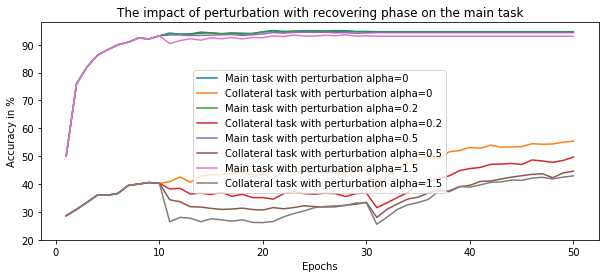

In [43]:
show_results(ffn_results, "The impact of perturbation with recovering phase on the main task", ymin=20, ymax=98)

As you observe, the sabotage task is very specific: you only need to change a bit the network structure to see that it manages again to find sufficient information to recover collateral information.
For example, in the case alpha=1.5, we recover from 33% to 43%.

## 3. Collateral Models of the same family

We try to use models with a single hidden layer, but with different size and different activations.

In [98]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [99]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self, hidden_sizes):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin3 = nn.Linear(8, 16)
        self.lin4 = nn.Linear(16, N_FONTS)
        
        # --- FFNs for font families advanced
        self.hidden_sizes = hidden_sizes
        for hidden_size in hidden_sizes:
            setattr(self, f"lin{hidden_size}_1", nn.Linear(8, hidden_size))
            setattr(self, f"lin{hidden_size}_2", nn.Linear(hidden_size, N_FONTS))        
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x
    
    def conv_font_advanced(self, x, i):
        # --- FFN
        lin1 = getattr(self, f"lin{self.hidden_sizes[i]}_1")
        lin2 = getattr(self, f"lin{self.hidden_sizes[i]}_2")        
        x = F.relu(lin1(x))
        x = lin2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font_advanced(self, x, i):
        x = self.quad(x)
        x = self.conv_font_advanced(x, i)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

In [100]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced_collateral, advanced_idx=-1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        if not advanced_collateral:
            # Optimize C and F parts of the model with 2 strategies
            if initial_phase:  # Normal optimisation of C
                # Phase 1: Optimise Q + C
                optimizer.zero_grad()
                output = model.forward_char(data)
                loss_char = F.nll_loss(output, target_char)
                loss_char.backward()
                optimizer.step()
            else: # Freezed(Q) optimisation
                # Phase 1: Optimise Freezed(Q) + C
                model.freeze('quad')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)
                loss_char.backward()
                optimizer.step()
                model.unfreeze()
            # Phase 2: Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()

            if perturbate:
                # Optimize Q
                model.freeze('font')
                model.freeze('char')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)

                output_font = model.forward_font(data)
                loss_font = F.nll_loss(output_font, target_font)

                loss = loss_char - alpha * loss_font
                loss.backward()
                optimizer.step()
                model.unfreeze()
        else:
            loss_char = None
            # advanced_collateral phase: use the advanced model
            model.freeze('quad')
            optimizer.zero_grad()
            output = model.forward_font_advanced(data, advanced_idx)
            loss_font = F.nll_loss(output, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        if loss_char is not None:
            loss_char = loss_char.item()
        else:
            loss_char = 0
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char, loss_font.item()))

In [101]:
def test(args, model, test_loader, advanced_collateral, advanced_idx=-1):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not advanced_collateral:
                output = model.forward_font(data)
            else:
                output = model.forward_font_advanced(data, advanced_idx)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [102]:
def main(alpha, hidden_sizes):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet(hidden_sizes)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    # Baseline training with collateral learning phase & protection
    collateral_setup_epochs = args.epochs + args.sabotage_epochs + args.recovering_epochs 
    for epoch in range(1, collateral_setup_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print(f"({epoch} initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print(f"({epoch} perturbate)")
        advanced = epoch > args.epochs + args.sabotage_epochs + args.recovering_epochs
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced)
        test_perf_char, test_perf_font = test(args, model, test_loader, advanced)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)
      
    test_perfs_font_dict = {}
    for model_idx in range(len(model.hidden_sizes)):
        collateral_accuracies = []
        for epoch in range(collateral_setup_epochs + 1, collateral_setup_epochs + args.advanced_epochs + 1):
            print(f"({epoch} advanced)")
            train(args, model, train_loader, optimizer, epoch, alpha, 
                initial_phase=False,
                perturbate=False,
                advanced_collateral=True,
                advanced_idx=model_idx)
            _, collateral_accuracy = test(
                args, model, test_loader, 
                advanced_collateral=True,
                advanced_idx=model_idx)
            collateral_accuracies.append(collateral_accuracy)
            
        test_perfs_font_dict[f"{model.hidden_sizes[model_idx]}"] = test_perfs_font + collateral_accuracies

    return test_perfs_char, test_perfs_font_dict, model

In [103]:
adversaries_results = {}
test_perfs_char, test_perfs_font_dict, model = main(alpha=1.5, hidden_sizes=[4, 8, 16, 32, 64])
for hidden_size, perf in test_perfs_font_dict.items():
    adversaries_results[f"Collateral task with hidden layer size = {hidden_size}"] = perf
adversaries_results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char

Training set 60000 items
Testing set  10000 items
(1 initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.272354 Loss Font: 1.607967
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.247684 Loss Font: 1.626060
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.141526 Loss Font: 1.658823
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.887372 Loss Font: 1.597490
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.810072 Loss Font: 1.592142
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.643772 Loss Font: 1.695651
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.105207 Loss Font: 1.567162
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.816756 Loss Font: 1.606306
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.800450 Loss Font: 1.599064
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.483095 Loss Font: 1.590013

Test set: Accuracy Char : 5065/10000 (50.65%)
          Accuracy Font : 2860/10000 (28.60%)
(2 initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.722953 Loss Font: 1.627678
Train E

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.153613 Loss Font: 1.370795
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.268509 Loss Font: 1.405057
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.269301 Loss Font: 1.323051
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.324503 Loss Font: 1.410451

Test set: Accuracy Char : 9321/10000 (93.21%)
          Accuracy Font : 3873/10000 (38.73%)
(11 perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.277737 Loss Font: 1.399181
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.212559 Loss Font: 1.675281
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.370681 Loss Font: 1.703925
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.247885 Loss Font: 1.639330
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.291143 Loss Font: 1.521241
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.078640 Loss Font: 1.563355
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.195793 Loss Font: 1.560677
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.169394 Loss 

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.153786 Loss Font: 1.567833
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.052756 Loss Font: 1.583390
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.052354 Loss Font: 1.587689
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.046743 Loss Font: 1.561001
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.064438 Loss Font: 1.572976
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.118614 Loss Font: 1.513676
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.105632 Loss Font: 1.587966
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.096994 Loss Font: 1.556805
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.333064 Loss Font: 1.491139

Test set: Accuracy Char : 9274/10000 (92.74%)
          Accuracy Font : 2714/10000 (27.14%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.169438 Loss Font: 1.637830
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.156588 Loss Font: 1.508055
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.068570 Loss Font: 1.586621
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.100046 Loss Font: 1.530875

Test set: Accuracy Char : 9302/10000 (93.02%)
          Accuracy Font : 3256/10000 (32.56%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.213672 Loss Font: 1.458754
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.167898 Loss Font: 1.435931
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.112906 Loss Font: 1.537415
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.270474 Loss Font: 1.485708
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.051727 Loss Font: 1.484809
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.133529 Loss Font: 1.562135
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.180557 Loss Font: 1.484425
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.077140 Loss Font: 1.520295
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.154774 Loss Font: 1.469582
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.050276 Loss Font: 1.533578

Test set: Accuracy Char : 9262/10000 (92.62%)
          Accuracy Font : 3256

Train Epoch: 39 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.619748
Train Epoch: 39 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.627609
Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.552809
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.592558
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.597867
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.616368
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.645499
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.611172

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2374/10000 (23.74%)
(40 advanced)
###### tensor(0.4597, grad_fn=<SumBackward0>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.564168
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.580735
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.574839
Train Epoch: 40 [

Train Epoch: 48 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.586814
Train Epoch: 48 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.548892
Train Epoch: 48 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.582655
Train Epoch: 48 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.538048
Train Epoch: 48 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.563079
Train Epoch: 48 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.551617

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2330/10000 (23.30%)
(49 advanced)
###### tensor(0.4360, grad_fn=<SumBackward0>)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.607220
Train Epoch: 49 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.592857
Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.530216
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.545889
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.557555
Train Epoch: 49 [

Train Epoch: 37 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.577418
Train Epoch: 37 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.579968
Train Epoch: 37 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.516229
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.564495

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2684/10000 (26.84%)
(38 advanced)
###### tensor(-0.2524, grad_fn=<SumBackward0>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.517589
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.489011
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.596601
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.555667
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.525354
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.532286
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.570750
Train Epoch: 38 

Train Epoch: 46 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.542999
Train Epoch: 46 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.551966

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2771/10000 (27.71%)
(47 advanced)
###### tensor(-0.2914, grad_fn=<SumBackward0>)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.575348
Train Epoch: 47 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.653273
Train Epoch: 47 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.545730
Train Epoch: 47 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.566723
Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.569219
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.568043
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.540878
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.612772
Train Epoch: 47 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.513052
Train Epoch: 47 

Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.608224

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2786/10000 (27.86%)
(36 advanced)
###### tensor(0.0329, grad_fn=<SumBackward0>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.615878
Train Epoch: 36 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.585092
Train Epoch: 36 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.548713
Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.568809
Train Epoch: 36 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.579731
Train Epoch: 36 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.606978
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.618253
Train Epoch: 36 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.528479
Train Epoch: 36 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.478535
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.546659

Test set: Accura


Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 3232/10000 (32.32%)
(45 advanced)
###### tensor(0.0028, grad_fn=<SumBackward0>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.465488
Train Epoch: 45 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.498777
Train Epoch: 45 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.529495
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.453646
Train Epoch: 45 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.491627
Train Epoch: 45 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.514305
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.528823
Train Epoch: 45 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.518445
Train Epoch: 45 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.530277
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.593859

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 3215/10000 (32.15%)


Train Epoch: 34 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.528269
Train Epoch: 34 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.571549
Train Epoch: 34 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.627796
Train Epoch: 34 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.581000
Train Epoch: 34 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.611414
Train Epoch: 34 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.586215
Train Epoch: 34 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.514718
Train Epoch: 34 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.599804

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2902/10000 (29.02%)
(35 advanced)
###### tensor(0.6513, grad_fn=<SumBackward0>)
Train Epoch: 35 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.573188
Train Epoch: 35 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.522828
Train Epoch: 35 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.528941
Train Epoch: 35 [

Train Epoch: 43 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.463642
Train Epoch: 43 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.417057
Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.444993
Train Epoch: 43 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.514479
Train Epoch: 43 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.461631
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.478077

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 3788/10000 (37.88%)
(44 advanced)
###### tensor(0.6076, grad_fn=<SumBackward0>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.396903
Train Epoch: 44 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.365258
Train Epoch: 44 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.361611
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.388656
Train Epoch: 44 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.496181
Train Epoch: 44 [

Train Epoch: 32 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.632514
Train Epoch: 32 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.709033
Train Epoch: 32 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.625952
Train Epoch: 32 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.488576

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 2924/10000 (29.24%)
(33 advanced)
###### tensor(-2.0018, grad_fn=<SumBackward0>)
Train Epoch: 33 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.597213
Train Epoch: 33 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.515057
Train Epoch: 33 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.538296
Train Epoch: 33 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.461306
Train Epoch: 33 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.571105
Train Epoch: 33 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.471799
Train Epoch: 33 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.511284
Train Epoch: 33 

Train Epoch: 41 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.317117
Train Epoch: 41 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.386522
Train Epoch: 41 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.316938

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 4076/10000 (40.76%)
(42 advanced)
###### tensor(-2.0463, grad_fn=<SumBackward0>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.509520
Train Epoch: 42 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.444225
Train Epoch: 42 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.440228
Train Epoch: 42 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.443713
Train Epoch: 42 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.416808
Train Epoch: 42 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.345941
Train Epoch: 42 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.378950
Train Epoch: 42 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.314242
Train Epoch: 42 

Train Epoch: 50 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.317542
Train Epoch: 50 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.231626

Test set: Accuracy Char : 9231/10000 (92.31%)
          Accuracy Font : 4371/10000 (43.71%)


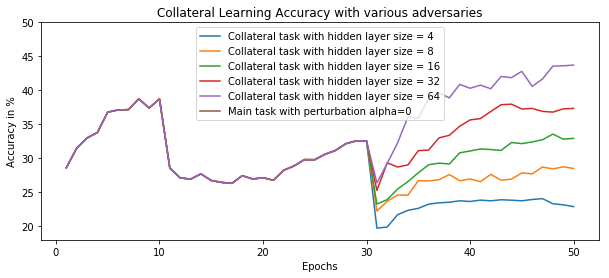

In [105]:
show_results(adversaries_results, "Collateral Learning Accuracy with various adversaries", ymin=18, ymax=50)

Here, the task with the hidden layer size = 16 corresponds to the one the model has been protected against. We observe that all models of the same family have results which are correlated to their complexity (ie size of the hidden layer): the more complex the model, the better the accuracy on the collateral task.

## 4. Collateral resistance againt the biggest model of a family

What if we now protect against the biggest model of the family ?

Here is a very light adaptation of the model.

In [110]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self, hidden_sizes):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin3 = nn.Linear(8, hidden_sizes[-1])
        self.lin4 = nn.Linear(hidden_sizes[-1], N_FONTS)
        
        # --- FFNs for font families advanced
        self.hidden_sizes = hidden_sizes
        for hidden_size in hidden_sizes:
            setattr(self, f"lin{hidden_size}_1", nn.Linear(8, hidden_size))
            setattr(self, f"lin{hidden_size}_2", nn.Linear(hidden_size, N_FONTS))        
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x
    
    def conv_font_advanced(self, x, i):
        # --- FFN
        lin1 = getattr(self, f"lin{self.hidden_sizes[i]}_1")
        lin2 = getattr(self, f"lin{self.hidden_sizes[i]}_2")        
        x = F.relu(lin1(x))
        x = lin2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font_advanced(self, x, i):
        x = self.quad(x)
        x = self.conv_font_advanced(x, i)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Note that we had to adapt alpha, otherwise we get a too intense perturbation and the learning task gets broken. So here $\alpha = 1$

In [118]:
adversaries_results2 = {}
test_perfs_char, test_perfs_font_dict, model = main(alpha=1, hidden_sizes=[4, 8, 16, 32, 64])
for hidden_size, perf in test_perfs_font_dict.items():
    adversaries_results2[f"Collateral task with hidden layer size = {hidden_size}"] = perf
adversaries_results2[f"Main task with perturbation alpha={alpha}"] = test_perfs_char

Training set 60000 items
Testing set  10000 items
(1 initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.286241 Loss Font: 1.609018
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.247849 Loss Font: 1.598065
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.163726 Loss Font: 1.634708
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.104518 Loss Font: 1.688110
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.910738 Loss Font: 1.646018
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.671627 Loss Font: 1.633236
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.152916 Loss Font: 1.597277
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.010512 Loss Font: 1.581153
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.821187 Loss Font: 1.583448
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.483732 Loss Font: 1.546628

Test set: Accuracy Char : 5116/10000 (51.16%)
          Accuracy Font : 2636/10000 (26.36%)
(2 initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.755876 Loss Font: 1.606897
Train E

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.166562 Loss Font: 1.077113
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.080314 Loss Font: 1.199561
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.090942 Loss Font: 1.257603
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.132712 Loss Font: 1.087511

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 5077/10000 (50.77%)
(11 perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.168307 Loss Font: 1.009409
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.487368 Loss Font: 1.640122
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.252652 Loss Font: 2.087796
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.484300 Loss Font: 1.564262
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.315906 Loss Font: 1.360006
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.272021 Loss Font: 1.523725
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.248225 Loss Font: 1.591510
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.453059 Loss 

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.078600 Loss Font: 1.549173
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.098920 Loss Font: 1.476209
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.133710 Loss Font: 1.459506
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.157148 Loss Font: 1.549908
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.136595 Loss Font: 1.417552
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.201799 Loss Font: 1.540630
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.134039 Loss Font: 1.585293
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.234526 Loss Font: 1.456535
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.304140 Loss Font: 1.525492

Test set: Accuracy Char : 9225/10000 (92.25%)
          Accuracy Font : 2991/10000 (29.91%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.091738 Loss Font: 1.553825
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.345817 Loss Font: 1.537973
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.212569 Loss Font: 1.511464
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.177336 Loss Font: 1.528939

Test set: Accuracy Char : 9228/10000 (92.28%)
          Accuracy Font : 3303/10000 (33.03%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.122539 Loss Font: 1.583029
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.125207 Loss Font: 1.475579
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.179293 Loss Font: 1.419866
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.243548 Loss Font: 1.596362
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.220615 Loss Font: 1.470284
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.023710 Loss Font: 1.552397
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.161480 Loss Font: 1.573617
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.094208 Loss Font: 1.416695
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.220526 Loss Font: 1.564115
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.239861 Loss Font: 1.487890

Test set: Accuracy Char : 9269/10000 (92.69%)
          Accuracy Font : 3493

Train Epoch: 39 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.635860
Train Epoch: 39 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.592494
Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.585469
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.619376
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.582977
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.578806
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.617866
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.645680

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2264/10000 (22.64%)
(40 advanced)
###### tensor(0.5970, grad_fn=<SumBackward0>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.570966
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.593547
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.601192
Train Epoch: 40 [

Train Epoch: 48 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.578960
Train Epoch: 48 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.609146
Train Epoch: 48 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.608525
Train Epoch: 48 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.593979
Train Epoch: 48 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.565141
Train Epoch: 48 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.593347

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2259/10000 (22.59%)
(49 advanced)
###### tensor(0.6159, grad_fn=<SumBackward0>)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.576090
Train Epoch: 49 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.580238
Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.590348
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.619477
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.548799
Train Epoch: 49 [

Train Epoch: 37 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.602557
Train Epoch: 37 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.631821
Train Epoch: 37 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.604670
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.599296

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2215/10000 (22.15%)
(38 advanced)
###### tensor(-0.9399, grad_fn=<SumBackward0>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.611407
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.598729
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.574238
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.584906
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.601186
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.612097
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.638588
Train Epoch: 38 

Train Epoch: 46 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.585809
Train Epoch: 46 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.589902
Train Epoch: 46 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.609834

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2261/10000 (22.61%)
(47 advanced)
###### tensor(-0.9149, grad_fn=<SumBackward0>)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.594296
Train Epoch: 47 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.561309
Train Epoch: 47 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.559963
Train Epoch: 47 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.608768
Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.625819
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.608101
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.593309
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.595723
Train Epoch: 47 

Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.600716

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2410/10000 (24.10%)
(36 advanced)
###### tensor(0.4903, grad_fn=<SumBackward0>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.609570
Train Epoch: 36 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.597164
Train Epoch: 36 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.597371
Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.558678
Train Epoch: 36 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.560729
Train Epoch: 36 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.551211
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.549626
Train Epoch: 36 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.595854
Train Epoch: 36 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.599240
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.528419

Test set: Accura


Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2635/10000 (26.35%)
(45 advanced)
###### tensor(0.4962, grad_fn=<SumBackward0>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.530919
Train Epoch: 45 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.643911
Train Epoch: 45 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.589331
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.615011
Train Epoch: 45 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.627101
Train Epoch: 45 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.519321
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.622733
Train Epoch: 45 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.535725
Train Epoch: 45 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.603824
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.496850

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2616/10000 (26.16%)


Train Epoch: 34 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.561573
Train Epoch: 34 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.551353
Train Epoch: 34 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.562551
Train Epoch: 34 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.605730
Train Epoch: 34 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.590719
Train Epoch: 34 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.535561
Train Epoch: 34 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.602096
Train Epoch: 34 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.558167
Train Epoch: 34 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.558496

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2663/10000 (26.63%)
(35 advanced)
###### tensor(-0.3843, grad_fn=<SumBackward0>)
Train Epoch: 35 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.664068
Train Epoch: 35 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.593643
Train Epoch: 35 [

Train Epoch: 43 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.600338
Train Epoch: 43 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.545398
Train Epoch: 43 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.576950
Train Epoch: 43 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.562078
Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.568951
Train Epoch: 43 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.517700
Train Epoch: 43 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.602191
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.628744

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 3098/10000 (30.98%)
(44 advanced)
###### tensor(-0.3862, grad_fn=<SumBackward0>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.540719
Train Epoch: 44 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.553691
Train Epoch: 44 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.503103
Train Epoch: 44 

Train Epoch: 32 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.682640
Train Epoch: 32 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.526195
Train Epoch: 32 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.578011
Train Epoch: 32 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.555176
Train Epoch: 32 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.513592
Train Epoch: 32 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.575493

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 2725/10000 (27.25%)
(33 advanced)
###### tensor(1.1928, grad_fn=<SumBackward0>)
Train Epoch: 33 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.597094
Train Epoch: 33 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.600227
Train Epoch: 33 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.475952
Train Epoch: 33 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.659658
Train Epoch: 33 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.604761
Train Epoch: 33 [

Train Epoch: 41 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.496136
Train Epoch: 41 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.495214
Train Epoch: 41 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.505922
Train Epoch: 41 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.498630
Train Epoch: 41 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.540394

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 3415/10000 (34.15%)
(42 advanced)
###### tensor(1.1635, grad_fn=<SumBackward0>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.488541
Train Epoch: 42 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.429304
Train Epoch: 42 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.471847
Train Epoch: 42 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.530060
Train Epoch: 42 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.528790
Train Epoch: 42 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.584352
Train Epoch: 42 [

Train Epoch: 50 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.391347
Train Epoch: 50 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.422472
Train Epoch: 50 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.419321

Test set: Accuracy Char : 9257/10000 (92.57%)
          Accuracy Font : 3398/10000 (33.98%)


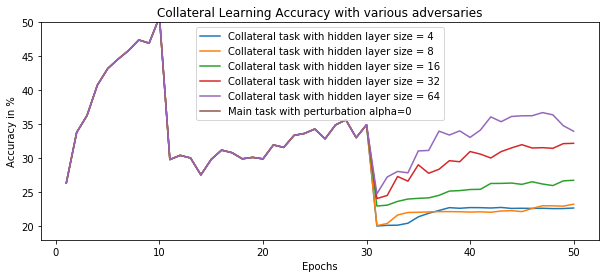

In [119]:
show_results(adversaries_results2, "Collateral Learning Accuracy with various adversaries", ymin=18, ymax=50)

So apparently, resisting against the biggest model of the family provides resistance against all smaller models, and accuracy for the collateral biggest model is `35.6%`.

## Conclusion

So we have seen that sabotage is not very general and is weak when it is exposed to different collateral models, especially models with more complexity.